In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os
import cv2
import h5py
import pickle
import sys
import scipy.io
from scipy.spatial import distance
%matplotlib inline

data_path = r"C:\Users\aewor\OneDrive - Emory University\Documents\Python\EmanuelLabRotation\01_processed ks practice"
npy_path = r"C:\Users\aewor\OneDrive - Emory University\Documents\Python\EmanuelLabRotation\00-npy"

In [2]:
os.environ['COMPUTERNAME']

## Use below code to import analyzeMEA module cloned from github

# #Need to cwd to import the cloned module analyzeMEA
# currPath = os.getcwd()
# print(currPath)

# # Set the working directory to the path of your cloned repository
# analyzeMEA_dir = r"C:\Users\aewor\Documents\GitHub\analyzeMEA"
# os.chdir(analyzeMEA_dir)
# import analyzeMEA

# os.chdir(currPath)

c:\Users\aewor\Documents\GitHub\NP_Analysis\NP_Analyze


## 0.1 Function to import phy-adjusted kilosort data.

### Inputs:
        
1. `data_path` - str with path to kilosort output
2. `depth` - int/float, depth of top electrode site for neuronexus_poly2.prb or depth of bottom electrode site for cnt_h4.prb, in microns (default 250 microns, my typical insertion depth of neuronexus_poly2 probe tip is 1100 microns)        
3. `sampleRate` - int sample rate in Hz (find in params.py if unknown)
    
### Output: Dict with keys
1. `goodSpikes` - ndarray of clusters (unit identities of spikes)
2. `goodSamples` - ndarray of spike samples (time of spike)
3. `goodTimes` - ndarray of spike times (in s)
4. `sampleRate` - int sample rate in Hz (same as input)

### Not yet implemented
1. ...
<!-- 1. `unitPosXY` - tuple of two ndarrays, (X center of mass, Y center of mass)
2. `depthIndices` - index of good units in the order of their depth
3. `depths` - depth of site (taking into account depth of probe)
4. `layers` - the cortical layer to which the depth corresponds
5. `units` - list of all units included in goodSpikes -->

In [23]:
def importphy(folderpath, tipDepth=4000, sampleRate=30000):
    """
    Import kilosort/phy2 outputs

        ## Inputs:
        1. `folderpath` - str with path to kilosort output
        2. `tipDepth` - int/float, depth of the shank tip in microns (Reading of D axis given by sensapex micromanipulator)
        3. `sampleRate` - int sample rate in Hz (find in params.py if unknown)
            
        ## Output: Dict with keys
        1. `sampleRate` - int sample rate in Hz (same as input)
        2. `goodSpikes` - ndarray of clusters (unit identities of spikes)
        3. `goodSamples` - ndarray of spike samples (time of spike)
        4. `goodTimes` - ndarray of spike times (in s)
        5. `clusterIDs` - ndarray of unit index as listed in the Kilosort/Phy output
        6. `goodIDs` - ndarray of all units included in goodSpikes
        7. `depths` - ndarray of recording site depth, order match with `clusterID` (counting the depth of shank)
        8. `nSpikes` - ndarray of number of spikes 

        ## Not yet implemented
        1. `unitPosXY` - tuple of two ndarrays, (X center of mass, Y center of mass)
        2. `depthIndices` - index of good units in the order of their depth
        3. `layers` - the cortical layer to which the depth corresponds
        4. 'waveforms of unit at its best site'
    """
    # parameters
    tipLength = 175 # the tip length of neuropixel 1.0 [unit: µm]

    # import the Kilosort data
    clusterInfo = pd.read_csv(folderpath+'/cluster_info.tsv',sep='\t')
    spikeClusters = np.load(folderpath+'/spike_clusters.npy')
    spikeTimes = np.load(folderpath+'/spike_times.npy')

    # apply label from manual curation 
    clusterInfo.loc[clusterInfo['group'] == 'good', 'KSLabel'] = 'good'

    # store units with good qualities
    try:
        goodIDs = np.array(clusterInfo['id'][clusterInfo['KSLabel'] == 'good'])
    except KeyError:
        goodIDs = np.array(clusterInfo['cluster_id'][clusterInfo['KSLabel'] == 'good'])
    
    # compute the depth
        siteDepth = tipDepth - tipLength - np.array(clusterInfo['depth'])
        if any(depth < 0 for depth in siteDepth):
            print("Warning: Negative depth value found, changing to 0.")
            siteDepth = [0 if depth < 0 else depth for depth in siteDepth]

    # write the output
    outDict = {}
    outDict['sampleRate'] = sampleRate
    outDict['goodSpikes'] = spikeClusters[np.array([n in goodIDs for n in spikeClusters])]
    outDict['goodSamples'] = np.int64(spikeTimes[np.array([n in goodIDs for n in spikeClusters])].reshape(-1))
    outDict['goodTimes'] = outDict['goodSamples']/sampleRate
    outDict['clusterIDs'] = np.array(clusterInfo['cluster_id']) ## to get a list of cluster ids
    outDict['goodIDs'] = goodIDs
    outDict['depths'] =  siteDepth
    outDict['nSpikes'] = np.array(clusterInfo['n_spikes']) ## to get number of spikes 
    #outDict['depthIndices'] = np.argsort(clusterInfo['depth']) ## to get an index to use for sorting by depth

    # print the number of good neurons
    print("Number of neurons passing the quality check: {}".format(len(goodIDs)))

    # report the sampling frequency
    print("Sampling frequency: {} Hz.".format(outDict['sampleRate']))
    
    return outDict

In [34]:
spikeDict = importphy(data_path, tipDepth=4050, sampleRate=30000)

goodSamples = spikeDict['goodSamples']
goodSpikes = spikeDict['goodSpikes']
goodTimes = spikeDict['goodTimes']
sampleRate = spikeDict['sampleRate']
depths = spikeDict['depths']

Number of neurons pass the quality check: 195
Sampling frequency: 30000 Hz.


In [ ]:
def importnpy(folderpath):
    """
    Import kilosort/phy2 outputs

        ## Inputs:
        1. `folderpath` - str with path to folder containing numpy arrays from NP_Optical trials
            
        ## Output: Dict with keys
        1. `sampleRate` - int sample rate in Hz (same as input)

        ## Not yet implemented
        1. `unitPosXY` - tuple of two ndarrays, (X center of mass, Y center of mass)
    """
    import os
    import numpy as np

    

    
    #Exports
    outDict = {}
    outDict['sampleRate'] = sampleRate

    return outDict

In [ ]:
npyDict = importnpy(npy_path)

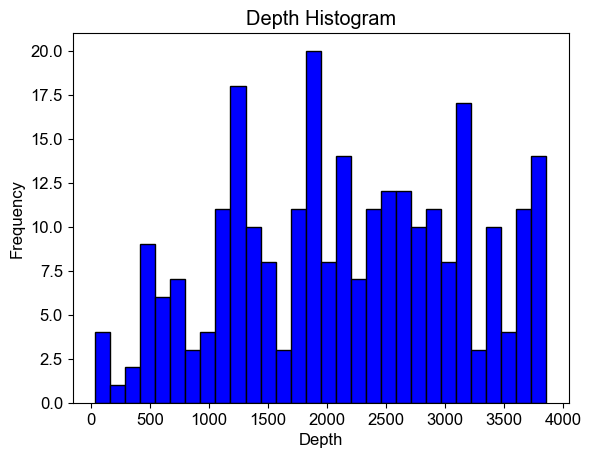

In [39]:
# Plotting the histogram
plt.hist(depths, bins=30, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Depth')
plt.ylabel('Frequency')
plt.title('Depth Histogram')

# Display the histogram
plt.show()

## 0.2 Plotting all units to ensure proper import.

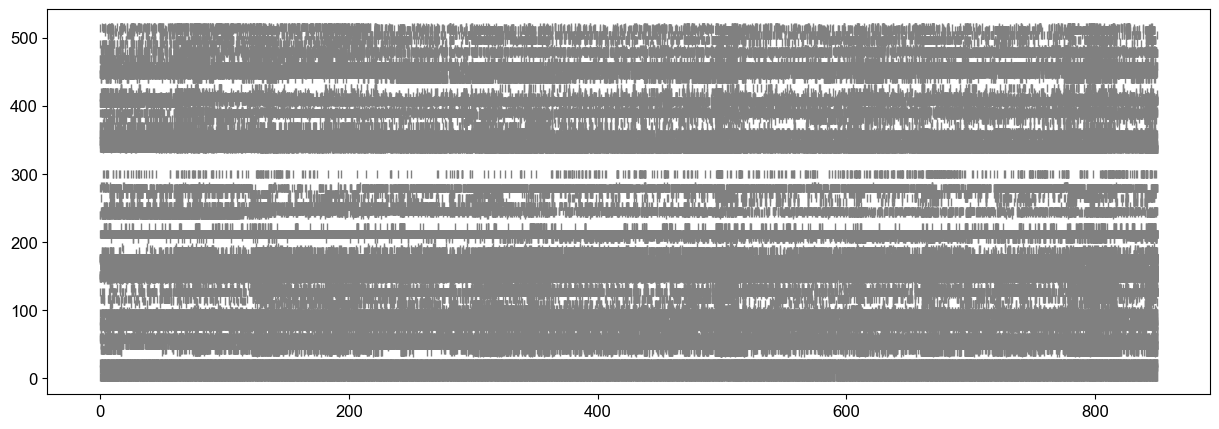

In [38]:
ltime = 0 # in seconds
rtime = 850 # in seconds

#plt.plot(goodtimes,goodspikes,'|')
plt.figure(figsize=(15,5))
plt.plot(goodTimes[(goodTimes > ltime) & (goodTimes < rtime)],goodSpikes[(goodTimes > ltime) & (goodTimes < rtime)],'|',color='gray')

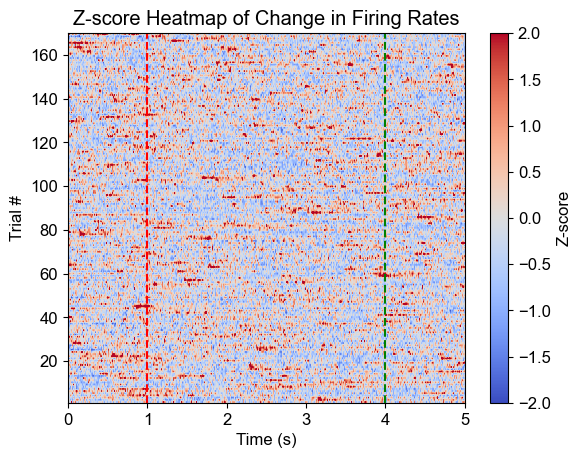

In [5]:
##Things to change: are bins overlapping? I'll need to only use relevant units instead of all units (see PSTHs)

from scipy.stats import zscore

# Define trial parameters
trial_duration = 5  # seconds
stim_onset = 1  # second
stim_ramp_down = 4  # seconds
stim_hold = stim_ramp_down - stim_onset  # seconds


# Number of trials
num_trials = 170

# Bin size for 10ms binning
bin_size = int(sampleRate * 0.01)
# Number of bins for the histogram
num_bins = int(trial_duration / 0.01) - 1

# Initialize arrays to store firing rates and stimulation signal
change_in_firing_rates = np.zeros((num_trials, int(trial_duration / 0.01) - 1))  # Adjusted size
stimulation_signal = np.zeros((num_trials, int(sampleRate * trial_duration)))

# Process each trial
for i in range(num_trials):
    start_index = i * int(sampleRate * trial_duration)
    end_index = (i + 1) * int(sampleRate * trial_duration)

    # Find indices within the specified range
    indices_within_range = [i for i, val in enumerate(goodSamples) if start_index <= val <= end_index]

    # Extract corresponding spike samples for all units
    trial_spikes_all_units = [goodSamples[i] for i in indices_within_range]

    # Calculate firing rates for the trial using np.histogram
    firing_rates, bins = np.histogram(trial_spikes_all_units, bins=np.arange(start_index, end_index + bin_size, bin_size))
    
    # Store firing rates for each trial
    change_in_firing_rates[i, :] = firing_rates[:num_bins]  # Firing rates for each bin

# Z-score the change in firing rates
z_scored_change = zscore(change_in_firing_rates, axis=1)

# Plotting
time_axis = np.linspace(0, trial_duration, int(trial_duration / 0.01) - 1)
trial_axis = np.arange(1, num_trials + 1)

# Create a z-score heatmap
plt.imshow(z_scored_change, aspect='auto', extent=[0, trial_duration, 1, num_trials], cmap='coolwarm', origin='lower', vmin=-2, vmax=2)  # Centered colormap

# Add stimulation onset, hold, and ramp-down lines
stimulation_onset = stim_onset
hold_duration = stim_hold
plt.axvline(x=stimulation_onset, linestyle='--', color='red', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration , linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Trial #')
plt.colorbar(label='Z-score')
plt.title('Z-score Heatmap of Change in Firing Rates')
plt.show()

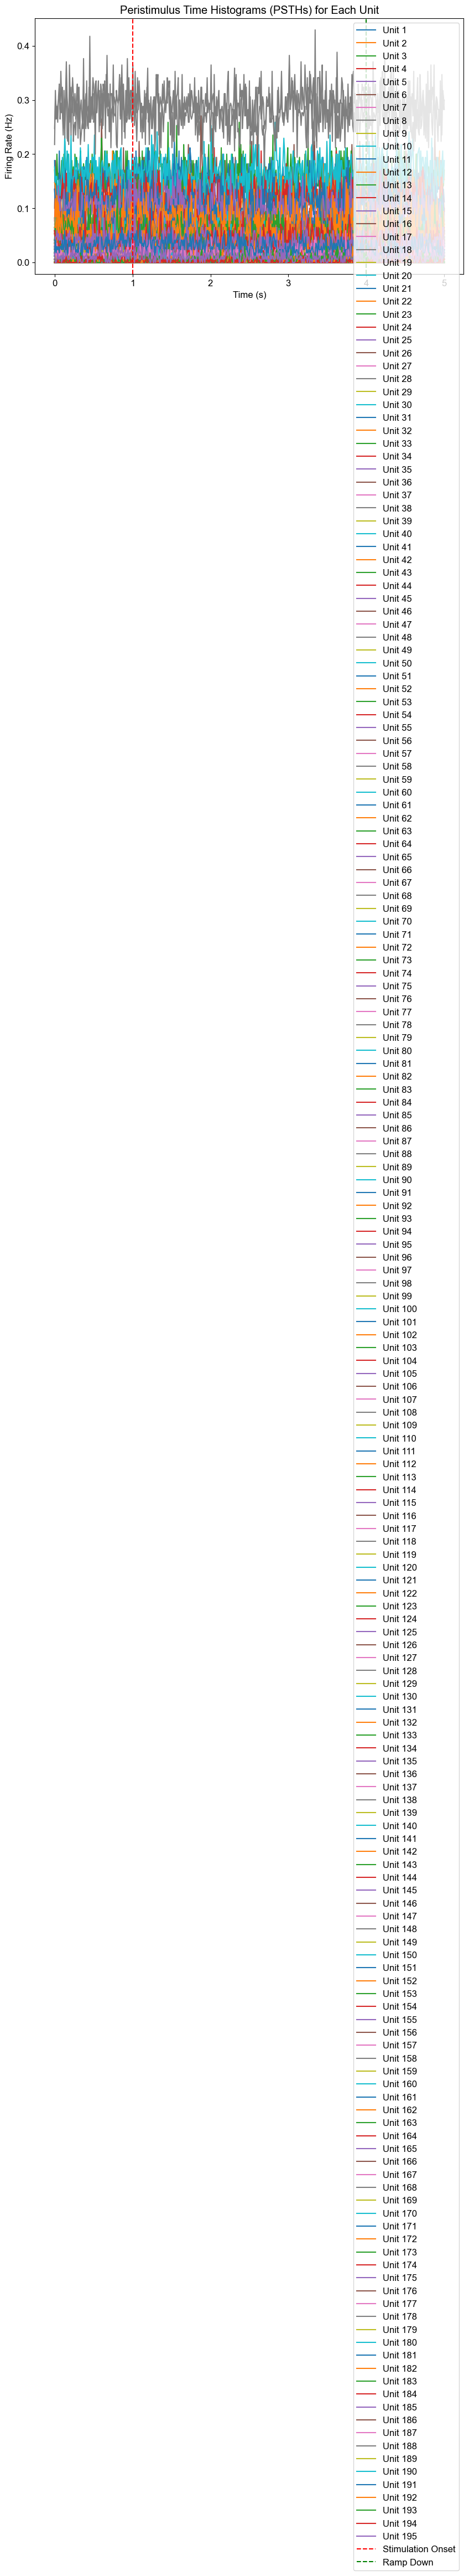

In [104]:
# Define trial parameters
num_trials = 170
bin_size = int(sampleRate * 0.01)  # 10ms bin size

# Initialize arrays to store PSTHs
psth_data = []

# Process each unit
for unit_id in np.unique(goodSpikes):
    # Get spike times for the current unit
    unit_spikes = [goodSamples[i] for i, unit in enumerate(goodSpikes) if unit == unit_id]

    # Initialize an array to store firing rates for each trial
    trial_firing_rates = np.zeros((num_trials, int(trial_duration / 0.01) - 1))

    # Process each trial
    for i in range(num_trials):
        start_index = i * int(sampleRate * trial_duration)
        end_index = (i + 1) * int(sampleRate * trial_duration)

        # Find indices within the specified range
        indices_within_range = [j for j, val in enumerate(unit_spikes) if start_index <= val <= end_index]

        # Extract corresponding spike samples for the trial
        trial_spikes = [unit_spikes[j] for j in indices_within_range]

        # Calculate firing rates for the trial using np.histogram
        firing_rates, bins = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

        # Ensure the firing rates array has the correct size
        if len(firing_rates) == num_bins + 1:
            firing_rates = firing_rates[:-1]

        # Store firing rates for each trial
        trial_firing_rates[i, :] = firing_rates

    # Compute the mean firing rate across trials (PSTH)
    mean_psth = np.mean(trial_firing_rates, axis=0)
    psth_data.append(mean_psth)

# Plotting PSTHs
time_axis = np.linspace(0, trial_duration, int(trial_duration / 0.01) - 1)
plt.figure(figsize=(10, 6))

for i, psth in enumerate(psth_data):
    plt.plot(time_axis, psth, label=f'Unit {i + 1}')

# Add stimulation onset, hold, and ramp-down lines
stimulation_onset = stim_onset
hold_duration = stim_hold
plt.axvline(x=stimulation_onset, linestyle='--', color='red', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration, linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Peristimulus Time Histograms (PSTHs) for Each Unit')
plt.legend()
plt.show()

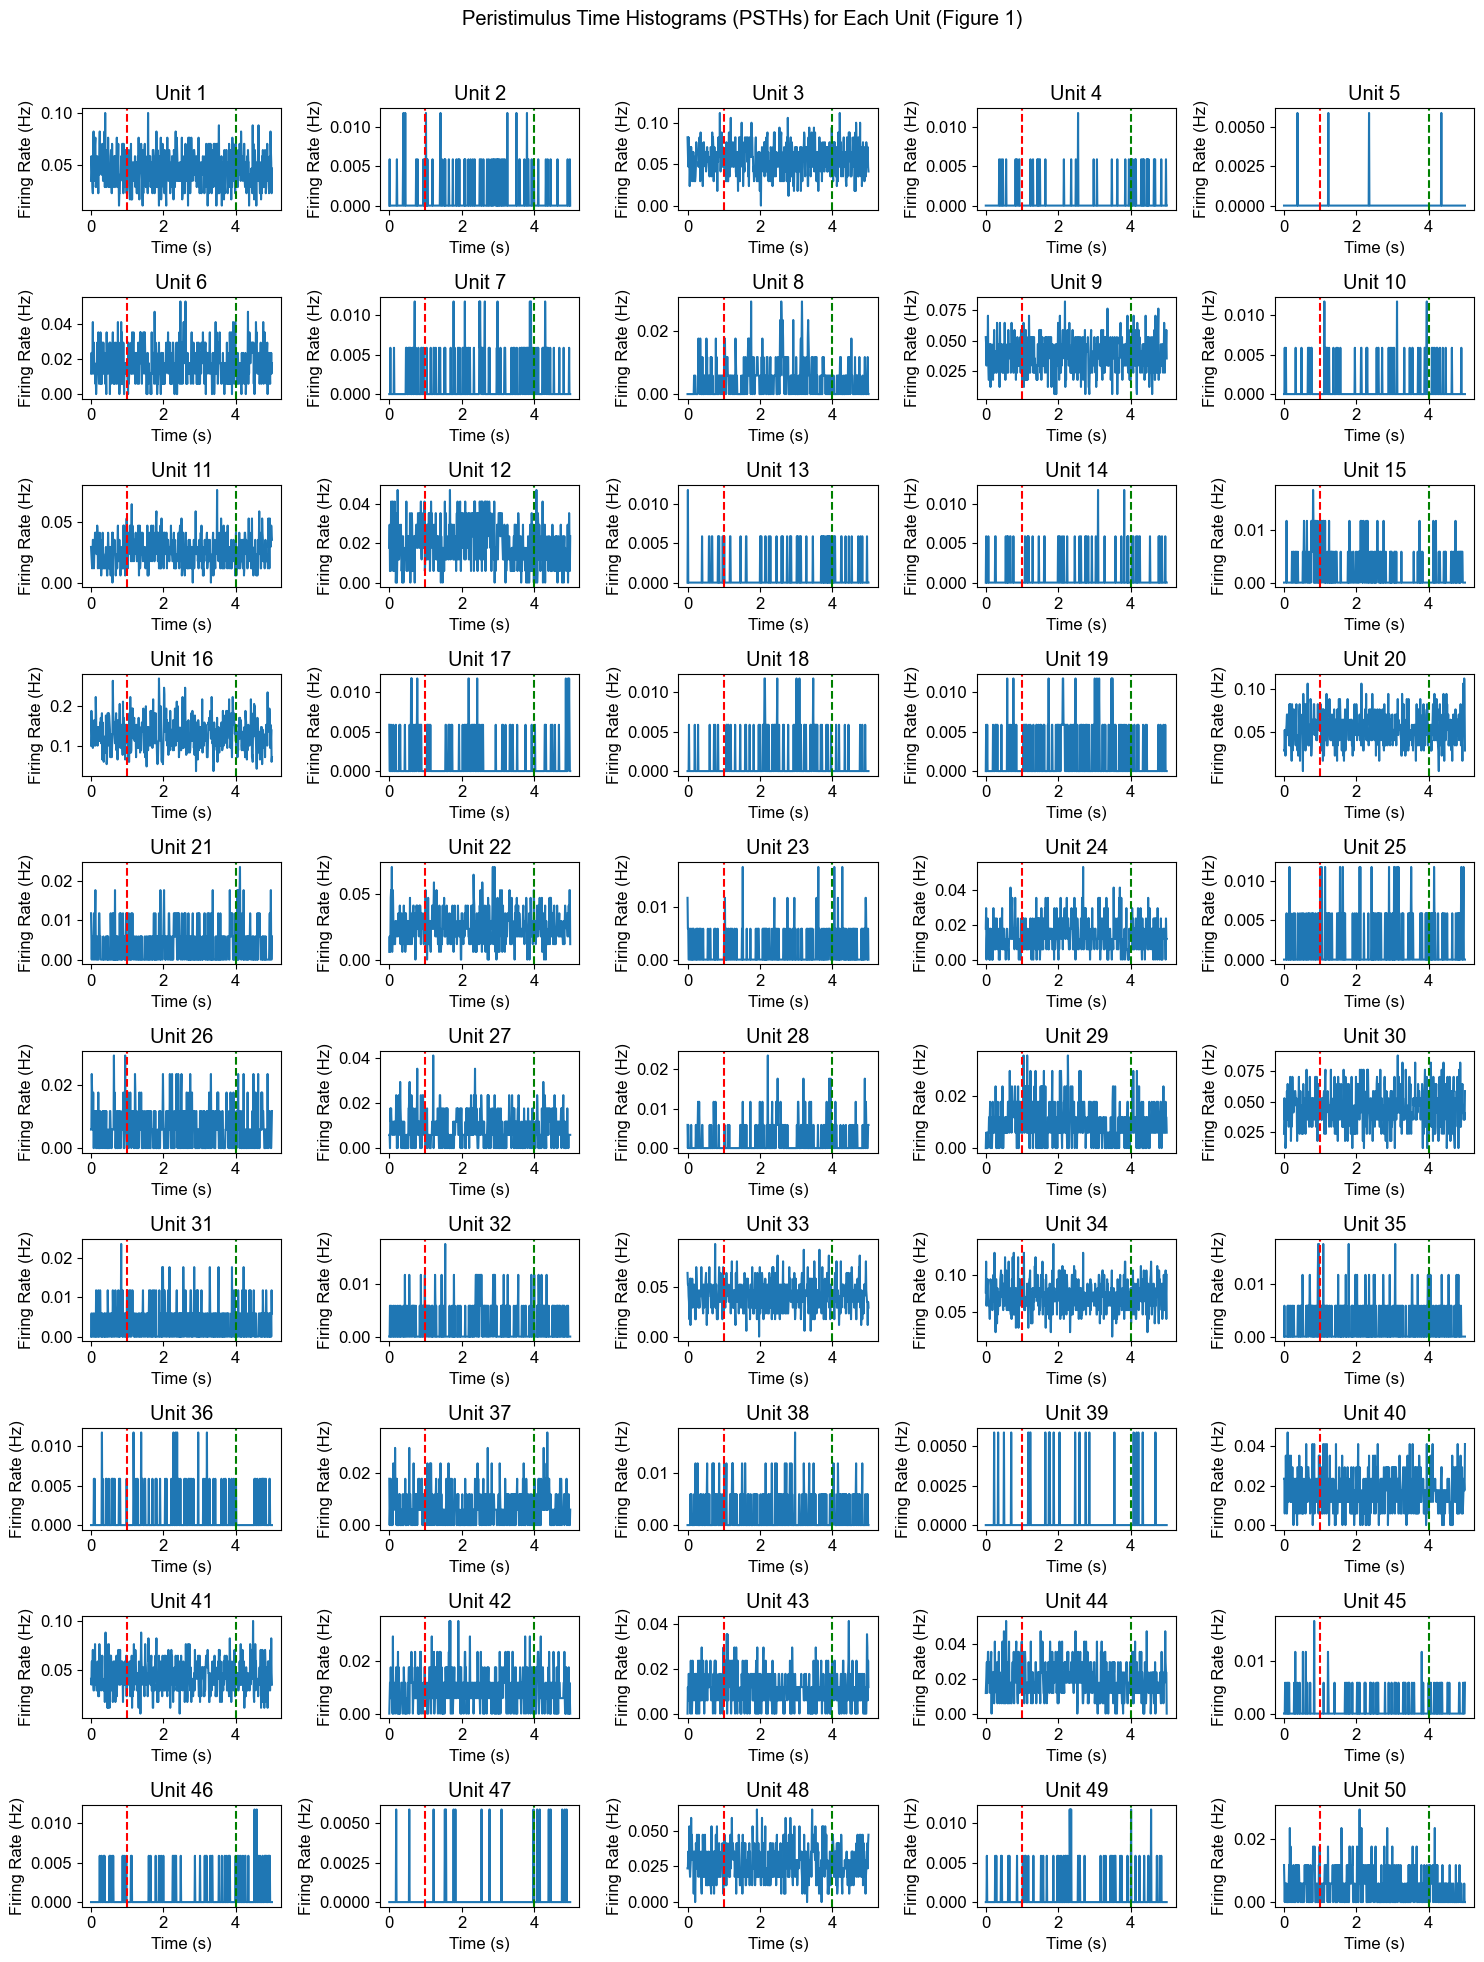

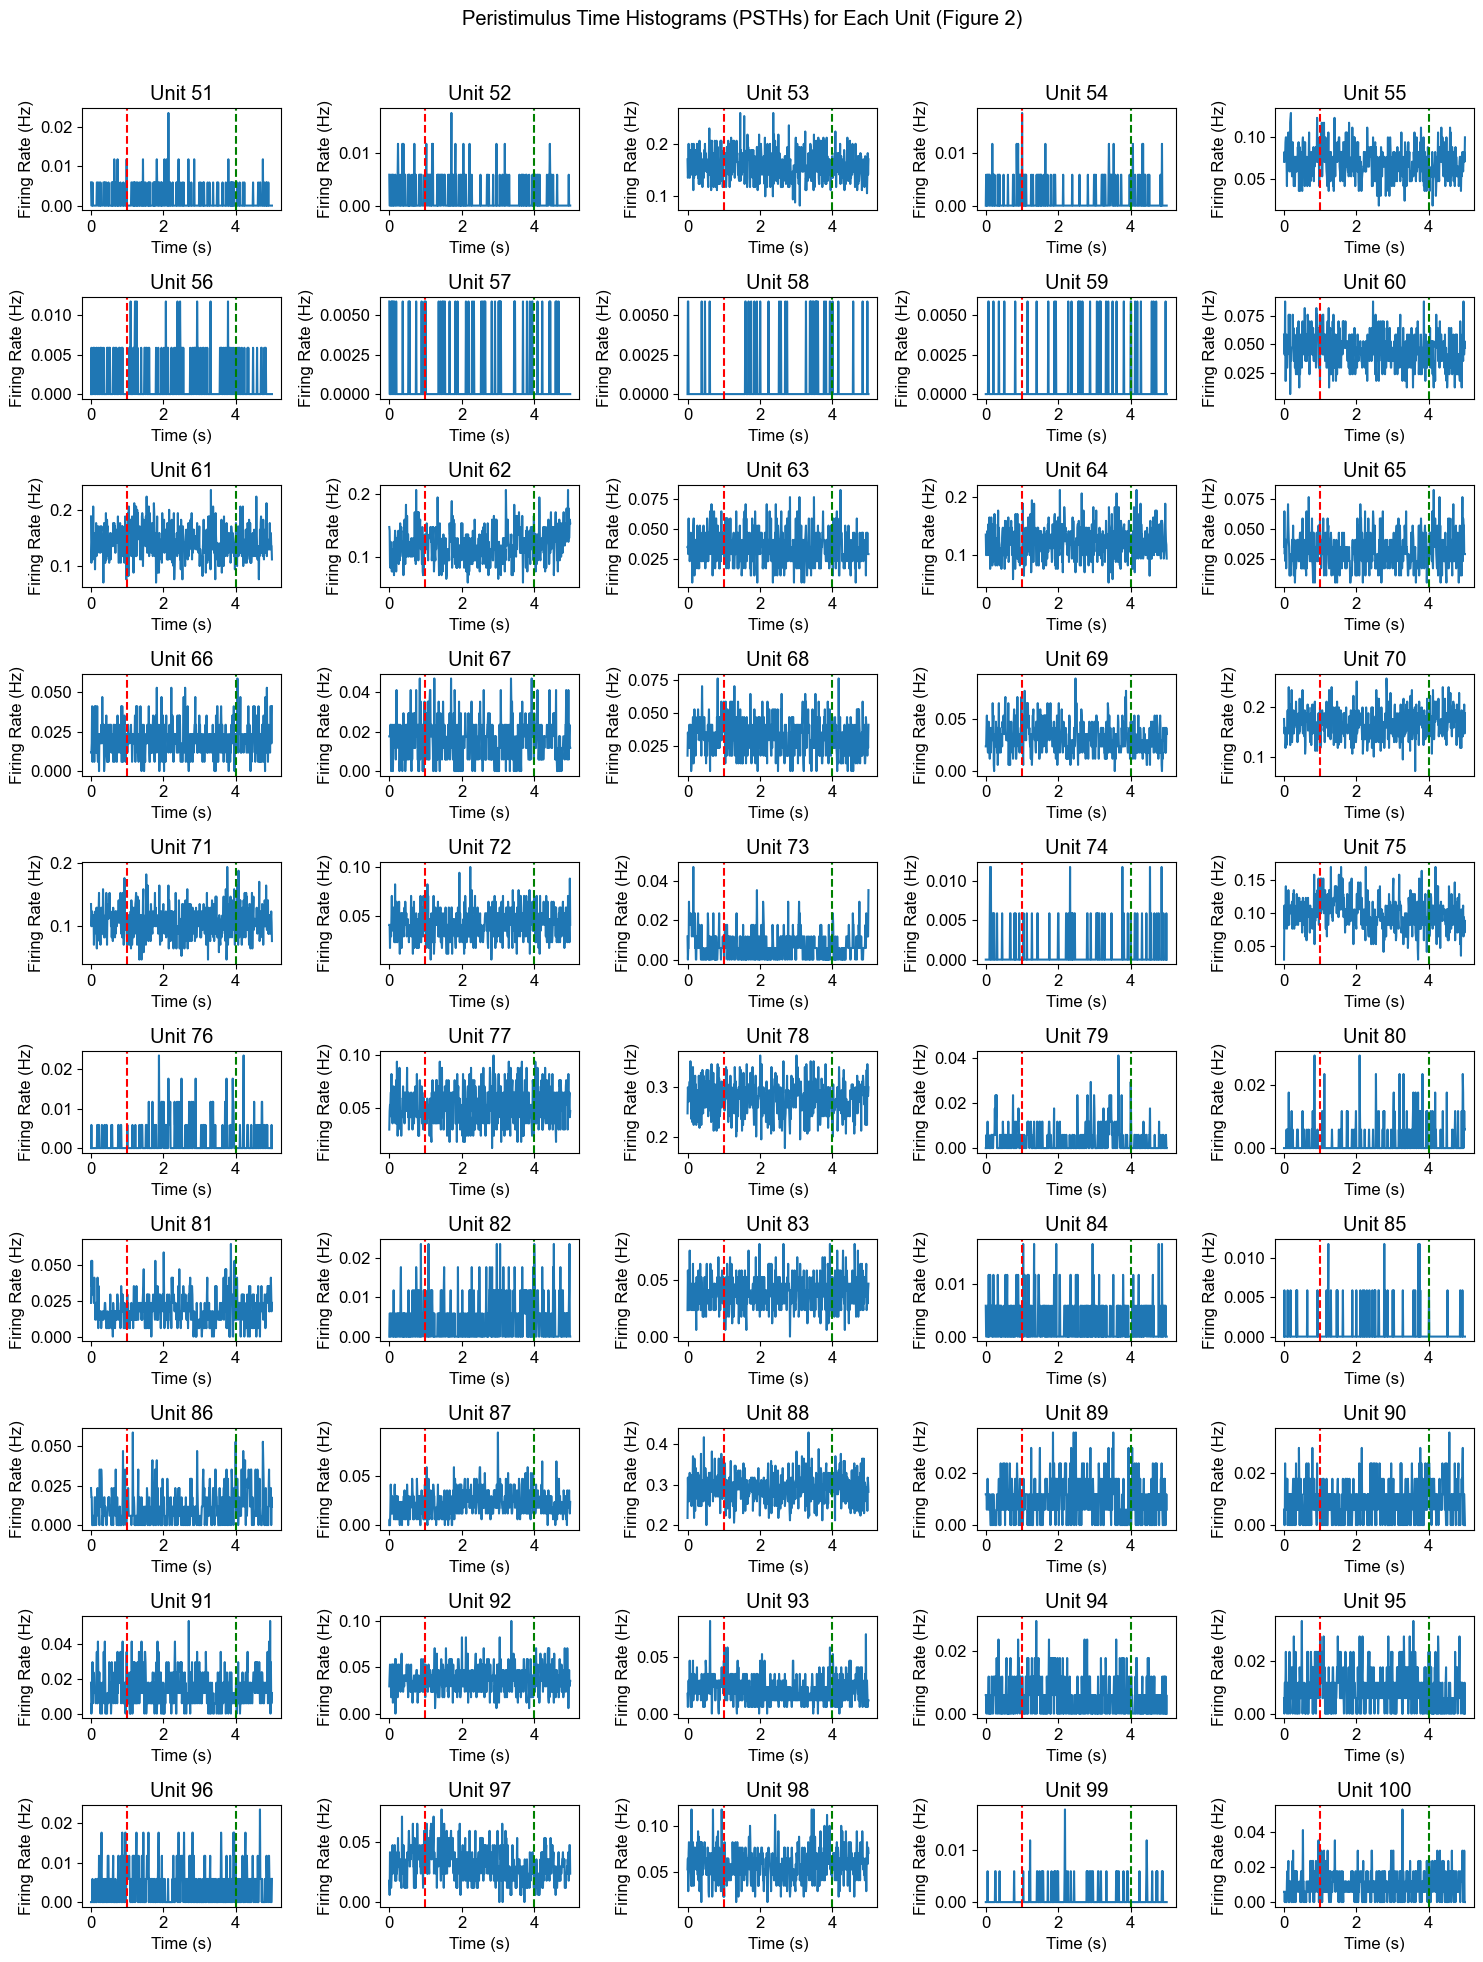

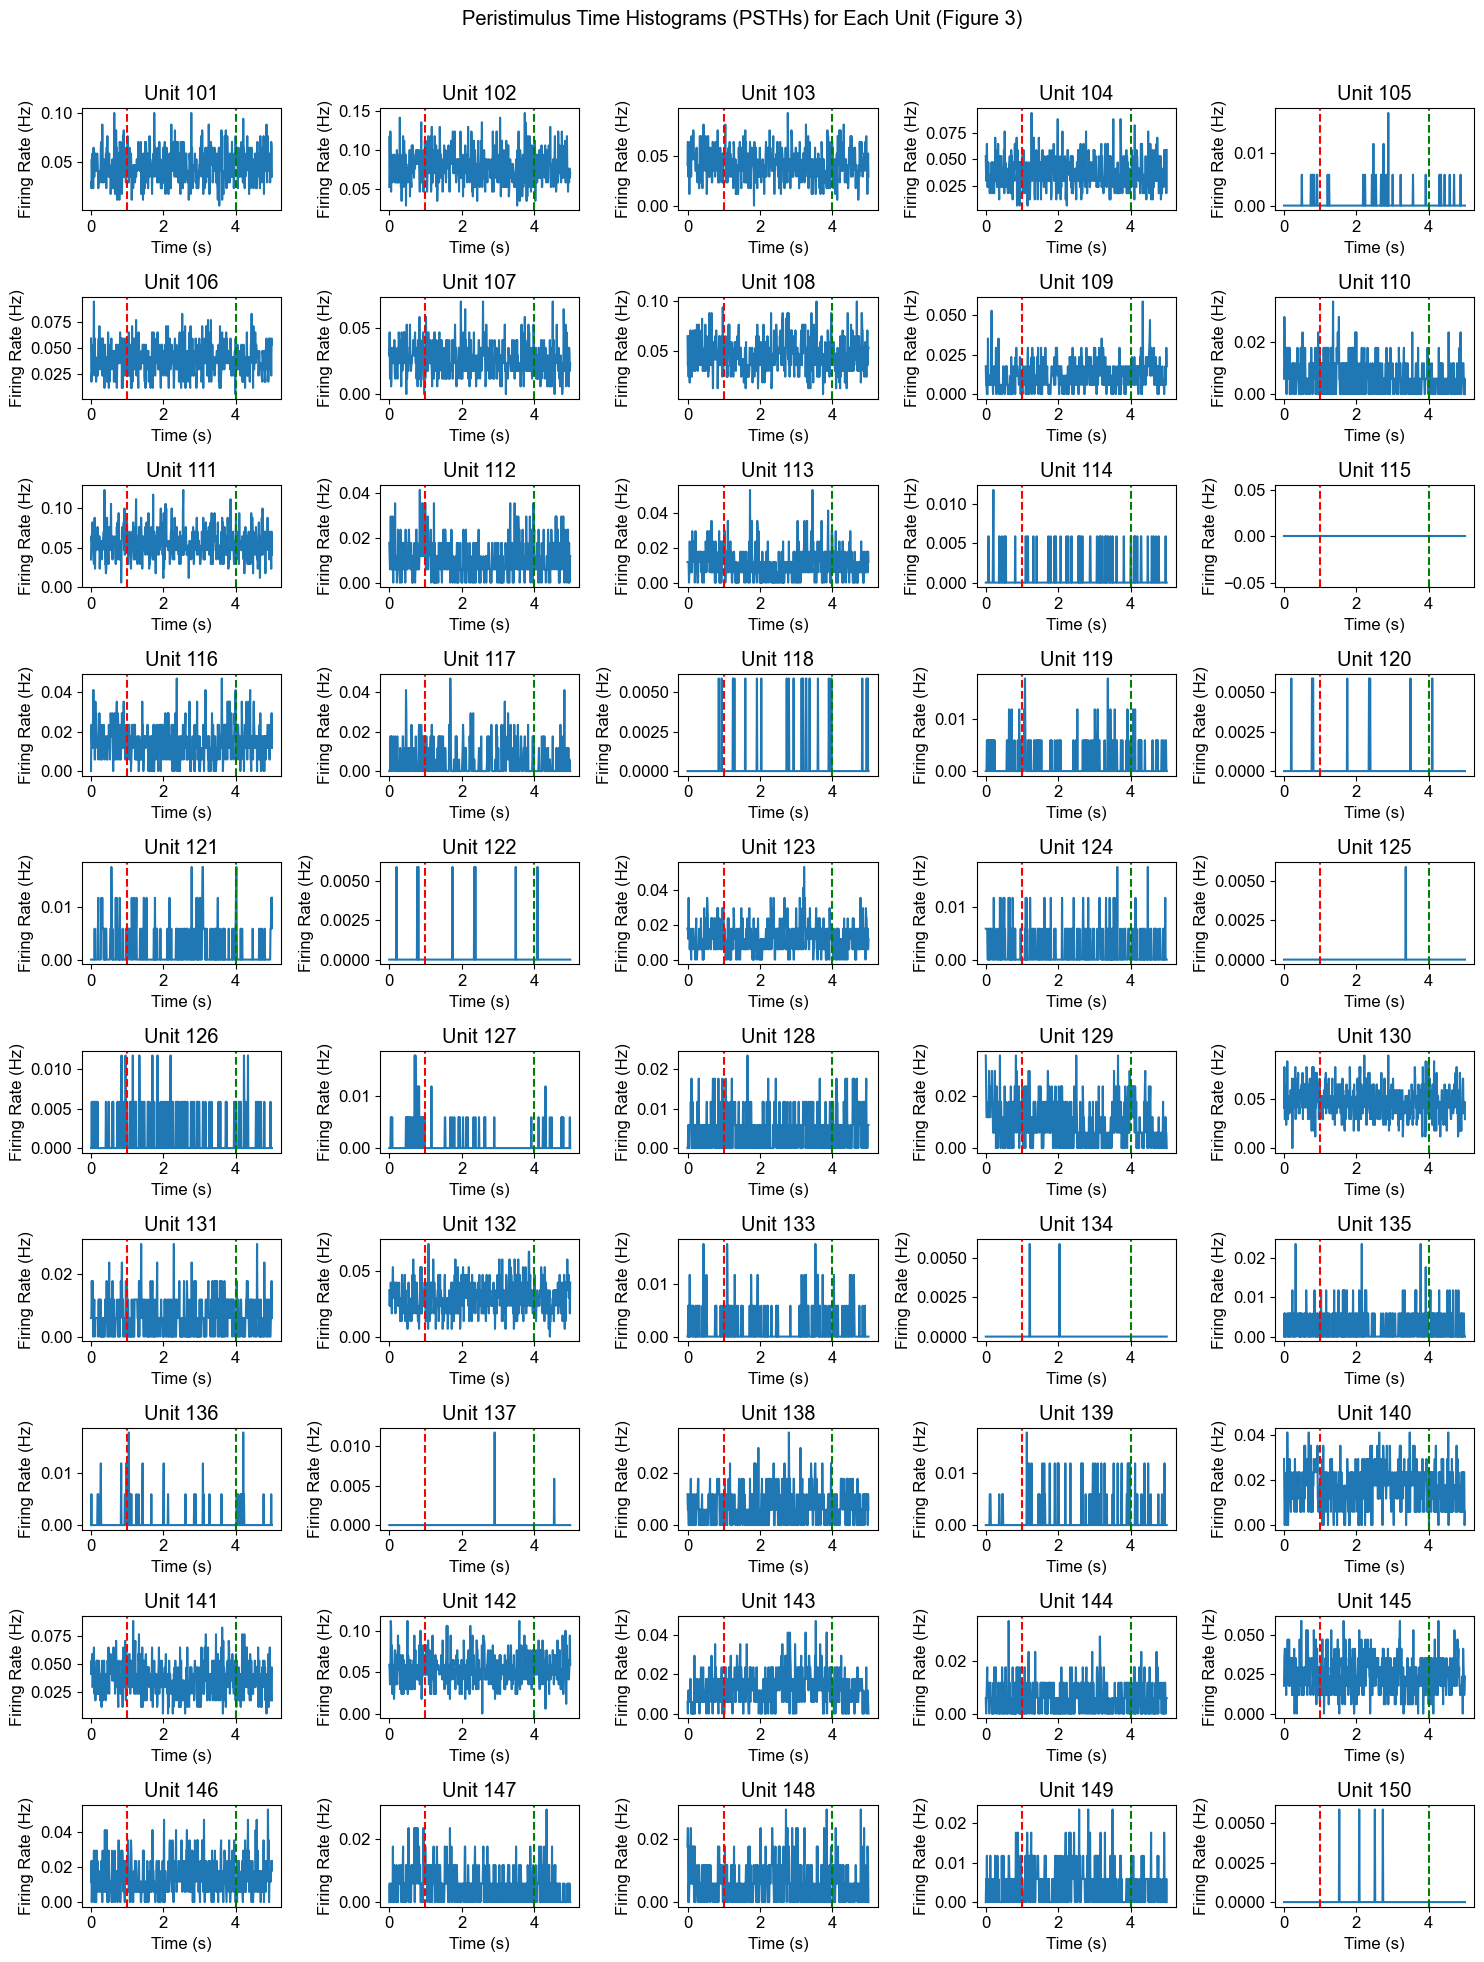

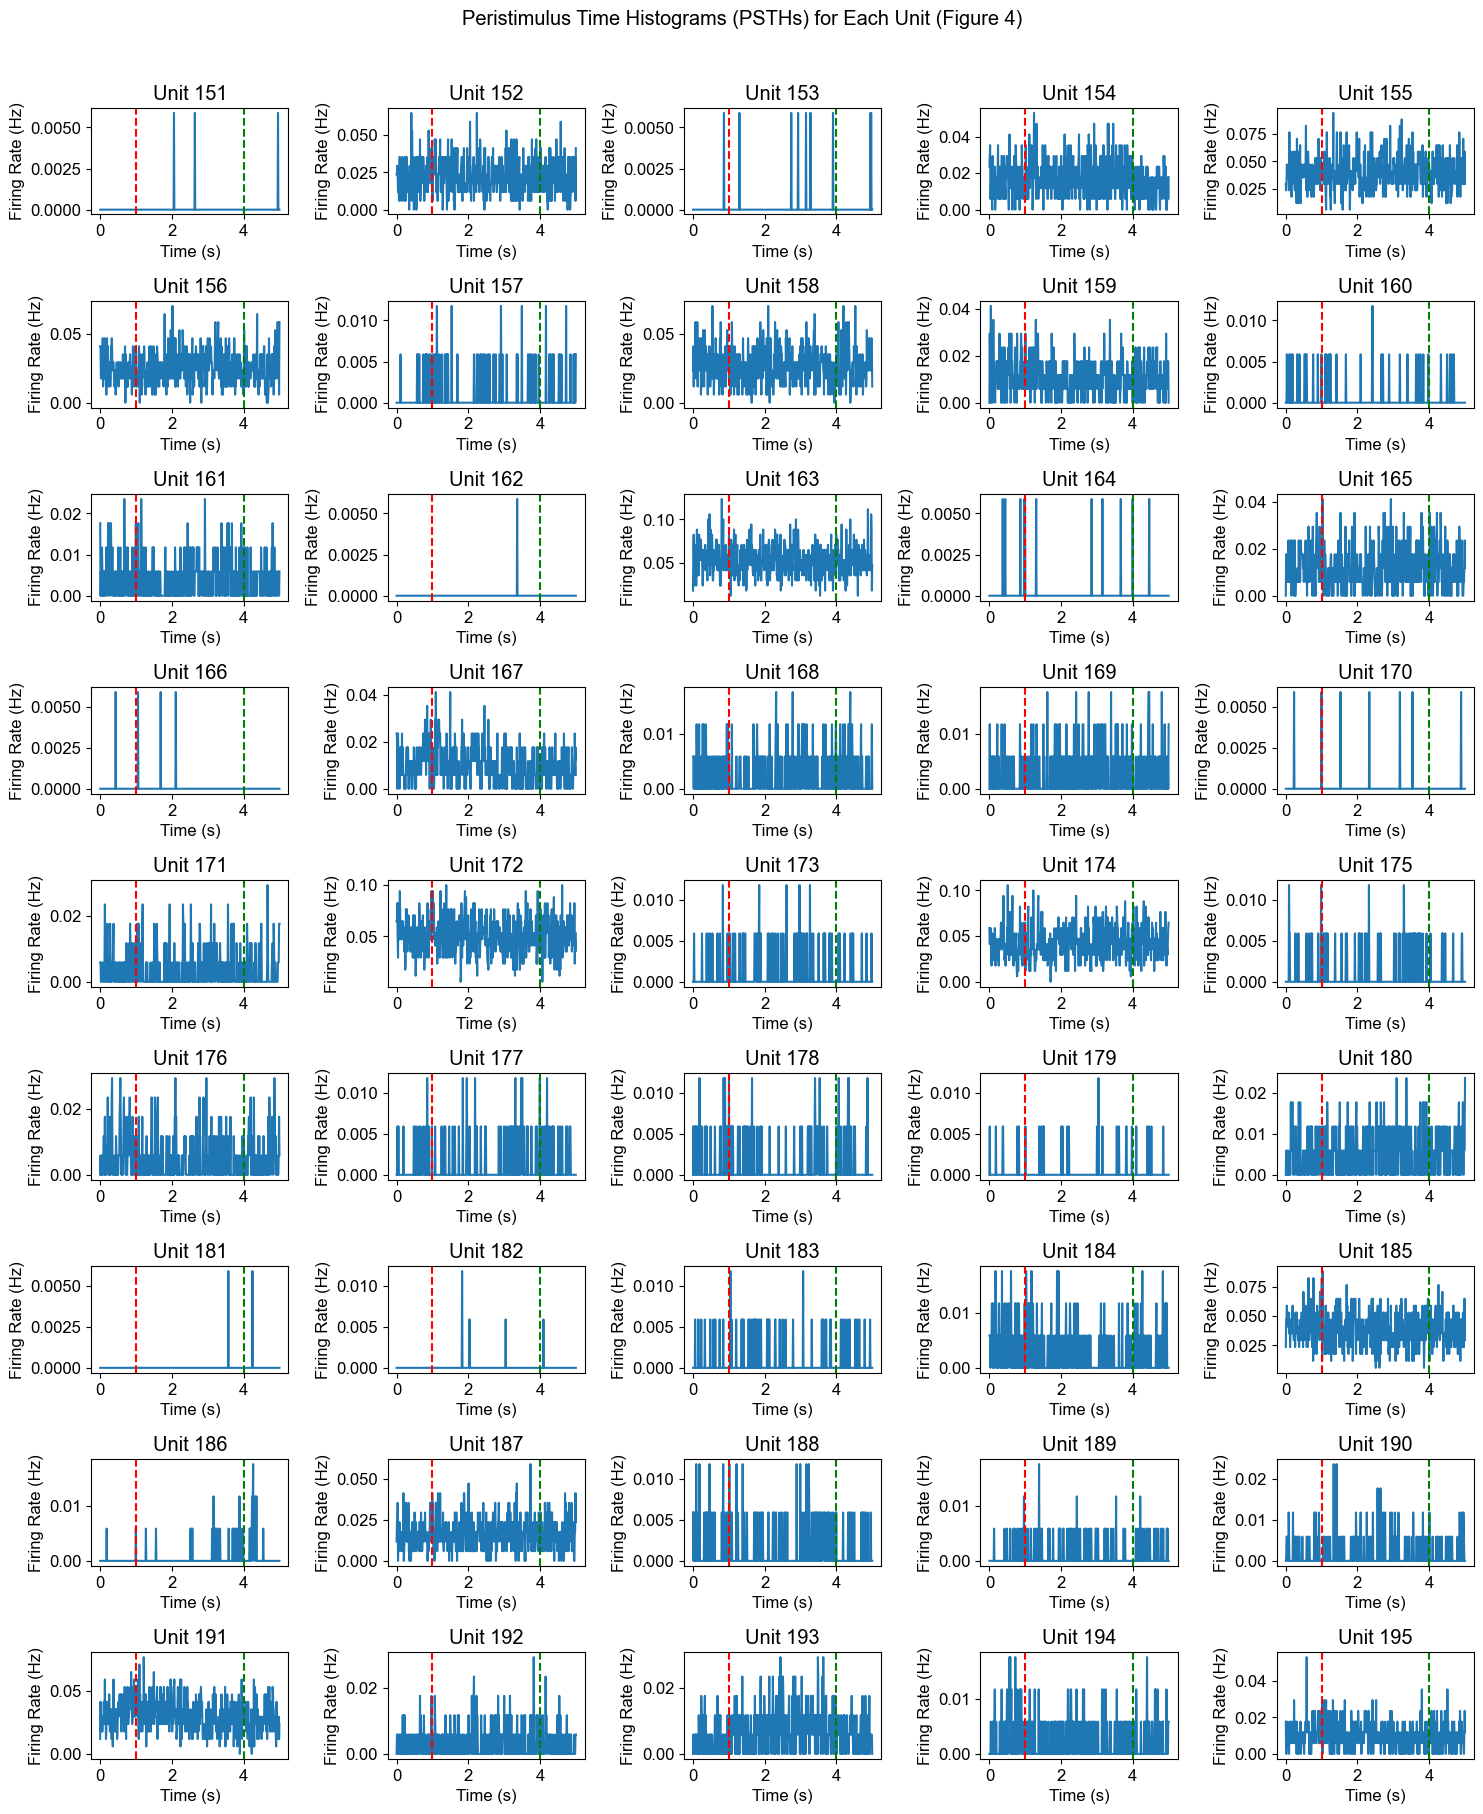

In [107]:
def calculate_psth(unit_spikes, num_trials, trial_duration, sample_rate):
    bin_size = int(sample_rate * 0.01)
    num_bins = int(trial_duration / 0.01) - 1

    trial_firing_rates = np.zeros((num_trials, num_bins))

    for i in range(num_trials):
        start_index = i * int(sample_rate * trial_duration)
        end_index = (i + 1) * int(sample_rate * trial_duration)

        indices_within_range = [j for j, val in enumerate(unit_spikes) if start_index <= val <= end_index]
        trial_spikes = [unit_spikes[j] for j in indices_within_range]

        firing_rates, bins = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

        if len(firing_rates) == num_bins + 1:
            firing_rates = firing_rates[:-1]

        trial_firing_rates[i, :] = firing_rates

    mean_psth = np.mean(trial_firing_rates, axis=0)
    return mean_psth

# Define trial parameters
num_trials = 170

# Initialize arrays to store PSTHs
psth_data = []

# Process each unit
for unit_id in np.unique(goodSpikes):
    unit_spikes = [goodSamples[i] for i, unit in enumerate(goodSpikes) if unit == unit_id]
    mean_psth = calculate_psth(unit_spikes, num_trials, trial_duration, sampleRate)
    psth_data.append(mean_psth)

# Plotting PSTHs in subplots with a limit of 50 subplots per figure
num_units = len(psth_data)
plots_per_figure = 50
num_figures = int(np.ceil(num_units / plots_per_figure))

for figure_num in range(num_figures):
    plt.figure(figsize=(15, 20))
    

    for i in range(plots_per_figure):
        unit_index = figure_num * plots_per_figure + i
        if unit_index < num_units:
            plt.subplot(10, 5, i + 1)
            plt.plot(np.linspace(0, trial_duration, len(psth_data[unit_index])), psth_data[unit_index])
            plt.title(f'Unit {unit_index + 1}')
            plt.xlabel('Time (s)')
            plt.ylabel('Firing Rate (Hz)')

            # Add stimulation onset, hold, and ramp-down lines
            stimulation_onset = stim_onset
            hold_duration = stim_hold
            plt.axvline(x=stimulation_onset, linestyle='--', color='red', label='Stimulation Onset')
            plt.axvline(x=stimulation_onset + hold_duration, linestyle='--', color='green', label='Ramp Down')

    plt.suptitle(f'Peristimulus Time Histograms (PSTHs) for Each Unit (Figure {figure_num + 1})')
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout for the suptitle
    plt.show()

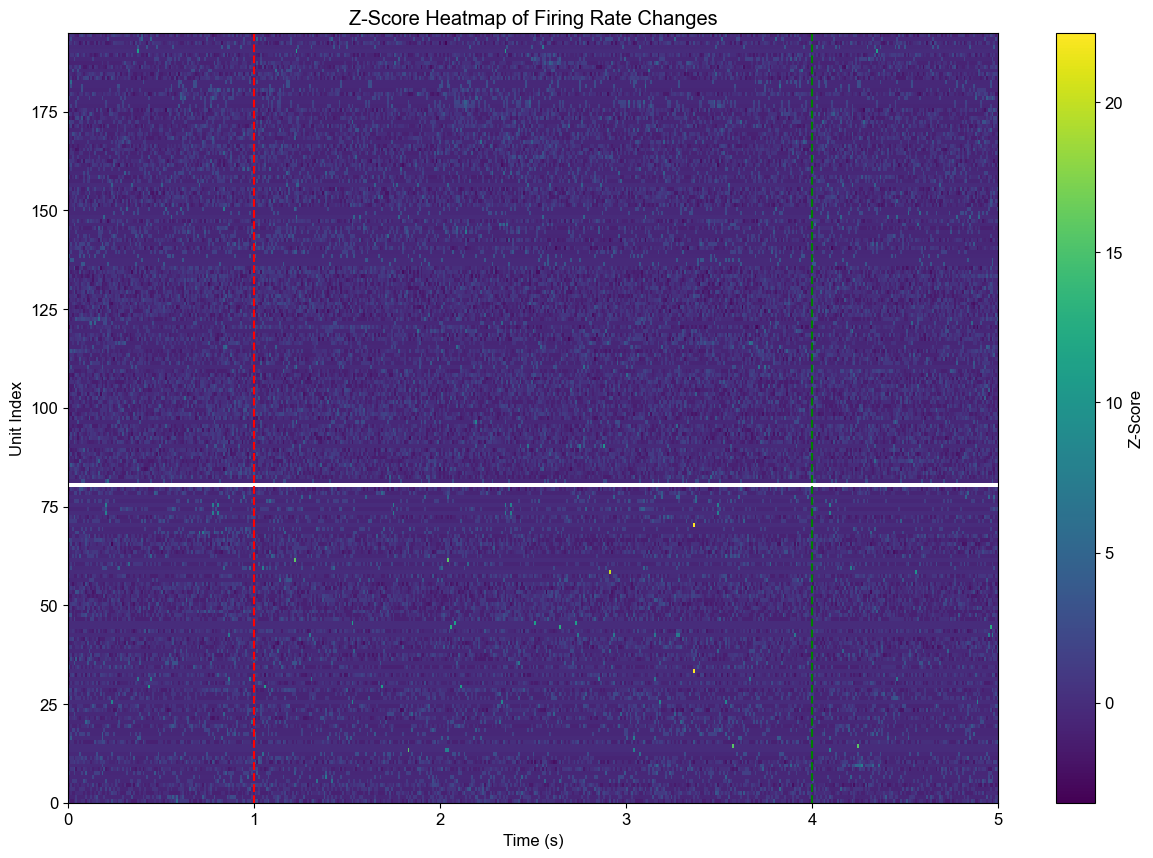

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Define trial parameters
num_trials = 170

# Initialize arrays to store PSTHs
psth_data = []

# Process each unit
for unit_id in np.unique(goodSpikes):
    unit_spikes = [goodSamples[i] for i, unit in enumerate(goodSpikes) if unit == unit_id]
    mean_psth = calculate_psth(unit_spikes, num_trials, trial_duration, sampleRate)
    psth_data.append(mean_psth)

# Calculate z-scores for each unit
zscore_data = np.array([zscore(psth) for psth in psth_data])

# Plotting z-score heatmap
plt.figure(figsize=(15, 10))
plt.imshow(zscore_data, aspect='auto', cmap='viridis', interpolation='nearest', extent=[0, trial_duration, 0, len(psth_data)])
plt.colorbar(label='Z-Score')

# Add stimulation onset, hold, and ramp-down lines
stimulation_onset = stim_onset
hold_duration = stim_hold
plt.axvline(x=stimulation_onset, linestyle='--', color='red', label='Stimulation Onset')
plt.axvline(x=stimulation_onset + hold_duration, linestyle='--', color='green', label='Ramp Down')

plt.xlabel('Time (s)')
plt.ylabel('Unit Index')
plt.title('Z-Score Heatmap of Firing Rate Changes')
plt.show()


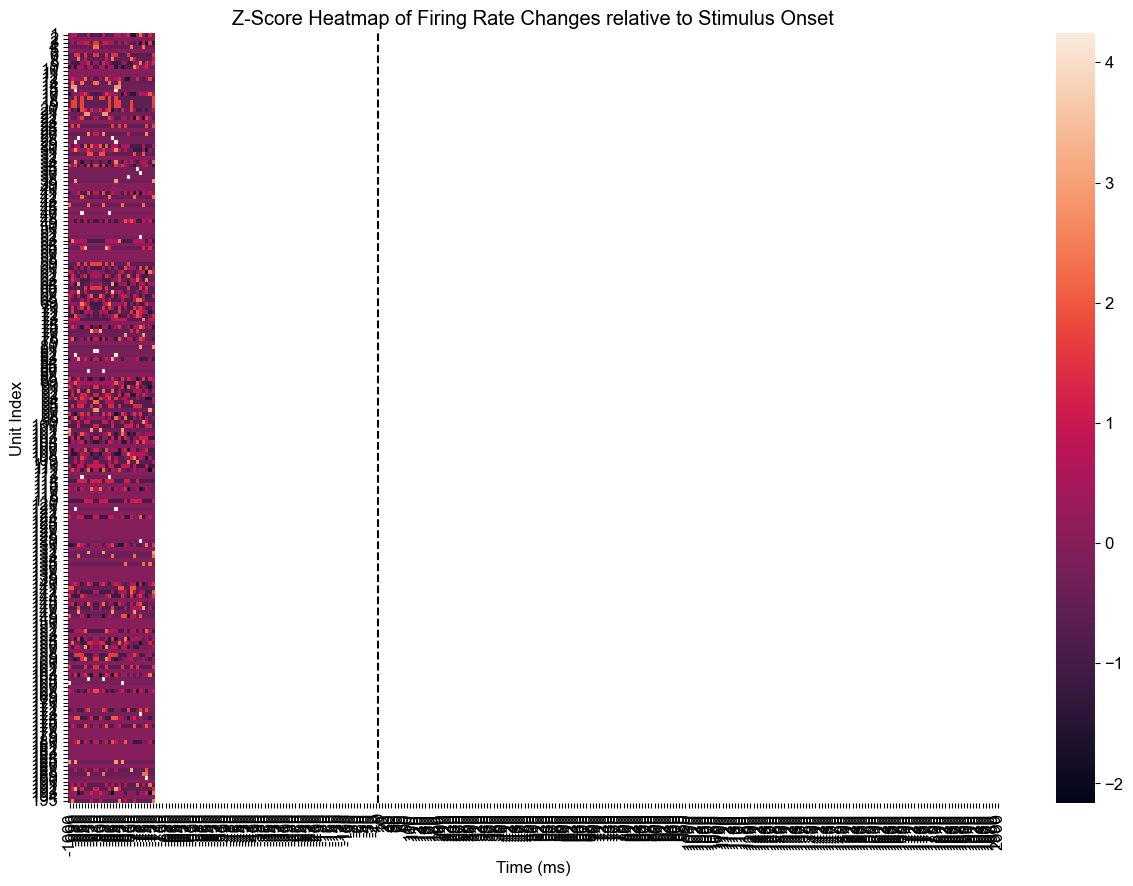

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Global variable for binning amount
bin_size_seconds = 0.1 #in seconds
bin_size = int(sampleRate * bin_size_seconds)


def calculate_psth(unit_spikes, num_trials, trial_duration, sample_rate):
    num_bins = int(trial_duration / bin_size_seconds) - 1

    trial_firing_rates = np.zeros((num_trials, num_bins))

    for i in range(num_trials):
        start_index = i * int(sample_rate * trial_duration)
        end_index = (i + 1) * int(sample_rate * trial_duration)

        indices_within_range = [j for j, val in enumerate(unit_spikes) if start_index <= val <= end_index]
        trial_spikes = [unit_spikes[j] for j in indices_within_range]

        firing_rates, bins = np.histogram(trial_spikes, bins=np.arange(start_index, end_index + bin_size, bin_size))

        if len(firing_rates) == num_bins + 1:
            firing_rates = firing_rates[:-1]

        trial_firing_rates[i, :] = firing_rates

    mean_psth = np.mean(trial_firing_rates, axis=0)
    return mean_psth

# Define trial parameters
num_trials = 170
post_stimulation_duration = 2  # in seconds
pre_stimulation_duration = 1  # in seconds
stim_onset = pre_stimulation_duration  # Stimulus onset time in seconds


# Initialize arrays to store PSTHs
psth_data = []

# Process each unit
for unit_id in np.unique(goodSpikes):
    unit_spikes = [goodSamples[i] for i, unit in enumerate(goodSpikes) if unit == unit_id]
    mean_psth = calculate_psth(unit_spikes, num_trials, trial_duration, sampleRate)
    psth_data.append(mean_psth)

# Calculate z-scores for each unit, handling division by zero
z_scores = []
for psth in psth_data:
    std_dev = np.std(psth)
    if std_dev == 0:
        z_scores.append(np.zeros_like(psth))
    else:
        z_scores.append((psth - np.mean(psth)) / std_dev)

# Convert z-scores list to NumPy array before slicing
z_scores_array = np.array(z_scores)

# Determine the number of bins for pre and post-stimulation
num_bins_pre_stim = int(pre_stimulation_duration / bin_size_seconds)
num_bins_post_stim = int(post_stimulation_duration / bin_size_seconds)

# Combine pre and post-stimulation data
combined_data = np.concatenate((z_scores_array[:, -num_bins_pre_stim-1::-1], z_scores_array[:, :num_bins_post_stim]), axis=1)

# Create x-axis tick positions and labels
time_ticks = np.arange(-pre_stimulation_duration * 1000, post_stimulation_duration * 1000 + 1, 10)
time_labels = [f'{t:.0f}' for t in time_ticks]

plt.figure(figsize=(15, 10))
sns.heatmap(combined_data, yticklabels=np.arange(1, len(z_scores) + 1), xticklabels=time_labels)
plt.axvline(x=int(stim_onset * 100), linestyle='--', color='black', label='Stimulation Onset')
plt.xlabel('Time (ms)')
plt.ylabel('Unit Index')
plt.title('Z-Score Heatmap of Firing Rate Changes relative to Stimulus Onset')
plt.show()